In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## データ生成
- データ数:N
- 入力変数Xの次元:1
- 出力変数Yの次元:1
サンプリングしたデータは[-0.75, 0.75]区間のみ

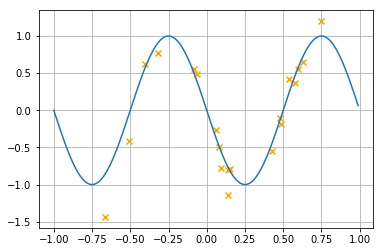

In [2]:
def f(x, s=0):
    y = -1 * np.sin(x*2*np.pi) #* np.exp(-(x**2) / (2*0.4**2))
    n = np.random.normal(0, s, size=y.shape)
    return y + n

# データ
N = 20
β = 5
x = np.random.uniform(-0.75, 0.75, size=N)
t = f(x, β**-1)

# データプロット
plt.grid()
plt.scatter(x, t, marker='x', color='orange')
plt.plot(np.arange(-1, 1, 0.01), f(np.arange(-1, 1, 0.01)))
plt.show()

## カーネル関数
- PRML (6.63)のカーネル関数
$$
k(\mathbf{x}_n, \mathbf{x}_m) = \theta_0\exp \left\{-\frac{\theta_1}{2} \|\mathbf{x}_n - \mathbf{x}_m\|^2\right\}
+\theta_2 + \theta_3 \mathbf{x}_n^\rm{T} \mathbf{x}_m
$$
各パラメータの微分は
$$
\begin{align}
\frac{\partial k}{\partial \theta_0} &= \exp \left\{-\frac{\theta_1}{2} \|\mathbf{x}_n - \mathbf{x}_m\|^2\right\} \\
\frac{\partial k}{\partial \theta_1} &= -\frac{\theta_0}{2} \|\mathbf{x}_n - \mathbf{x}_m\|^2 \exp \left\{-\frac{\theta_1}{2} \|\mathbf{x}_n - \mathbf{x}_m\|^2\right\} \\
\frac{\partial k}{\partial \theta_2} &= 1 \\
\frac{\partial k}{\partial \theta_2} &= \mathbf{x}_n^\rm{T} \mathbf{x}_m.
\end{align}
$$

0.34252549958834777 0.03815831952032822 0.2428246299305502 0.6006529032368962


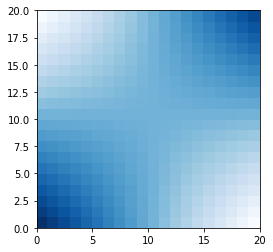

In [3]:
# カーネル関数
## PRML 式(6.63)
def gpr_kernel(x1, x2, θ0, θ1, θ2, θ3):
    return θ0 * np.exp(-1*θ1/2 *(x1-x2)**2) + θ2 + θ3*x1*x2

def grad_gpr_kernel(x1, x2, θ0, θ1, θ2, θ3):
    grad0 = np.exp(-1*θ1/2 *(x1-x2)**2)
    grad1 = (-1*θ0/2 *(x1-x2)**2) * np.exp(-1*θ1/2 *(x1-x2)**2)
    grad2 = np.ones_like(x1)
    grad3 = x1*x2
    return grad0, grad1, grad2, grad3

# カーネル関数からグラム行列を計算
def get_gram_matrix(x, *args):
    x1, x2 = np.meshgrid(x, x)
    return gpr_kernel(x1, x2, *args)

def get_grad_gram(x, *args):
    x1, x2 = np.meshgrid(x, x)
    return grad_gpr_kernel(x1, x2, θ0, θ1, θ2, θ3)


_x = np.arange(-1, 1, 0.1)
_θ0, _θ1, _θ2, _θ3 = np.random.rand(4)
K = get_gram_matrix(_x, _θ0, _θ1, _θ2, _θ3)
print(_θ0, _θ1, _θ2, _θ3)
plt.figure(figsize=(4,4))
plt.pcolormesh(K, cmap='Blues')
plt.show()

In [4]:
# ガウス過程での回帰問題
# hyper parameterの初期化
θ0, θ1, θ2, θ3 = np.random.rand(4)

# hyper parameterの最尤推定にて最適化
for i in range(1000):
    K = get_gram_matrix(x, θ0, θ1, θ2, θ3)
    C = K + np.eye(N) / β
    gradCs = get_grad_gram(x, θ0, θ1, θ2, θ3)
    Δθ0, Δθ1, Δθ2, Δθ3 = [
        -0.5*np.trace(np.linalg.inv(C)@gC) 
        +0.5*t@np.linalg.inv(C)@gC@np.linalg.inv(C)@t
        for gC in gradCs]

    θ0 += 0.1 * Δθ0
    θ1 += 0.1 * Δθ1
    θ2 += 0.1 * Δθ2
    θ3 += 0.1 * Δθ3

# kernel関数を用いてグラム行列(K)を計算
K = get_gram_matrix(x, θ0, θ1, θ2, θ3)
# 共分散行列C(K+β^-1I)を計算
C = K + np.eye(N) / β
# 観測していない点tN+1に対して計算
ms = []
vs = []
for x_new in np.arange(-1, 1, 0.01):
    k = gpr_kernel(x, x_new,  θ0, θ1, θ2, θ3)
    ms.append(k@np.linalg.inv(C)@t)
    
    c = gpr_kernel(x_new, x_new,  θ0, θ1, θ2, θ3) + 1/β
    vs.append(c - k@np.linalg.inv(C)@k)

ms = np.array(ms)
ss = np.sqrt(np.array(vs))

## 結果のプロット

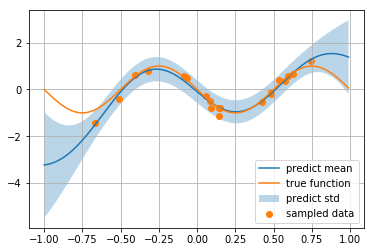

In [5]:
plt.plot(np.arange(-1, 1, 0.01), ms, label='predict mean')
plt.fill_between(np.arange(-1, 1, 0.01),ms+ss, ms-ss, alpha=0.3, label='predict std')
plt.scatter(x, t, label='sampled data')
plt.plot(np.arange(-1, 1, 0.01), f(np.arange(-1, 1, 0.01)), label='true function')
plt.grid()
plt.legend()
plt.show()